# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [2]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

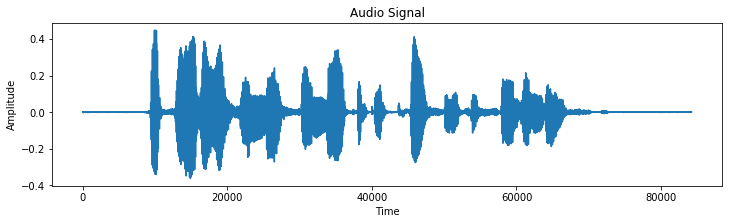

**Shape of Audio Signal** : (84231,)

**Transcript** : her father is a most remarkable person to say the least

In [3]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

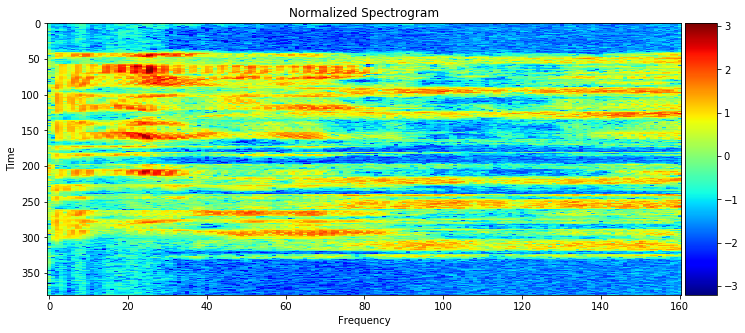

**Shape of Spectrogram** : (381, 161)

In [4]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

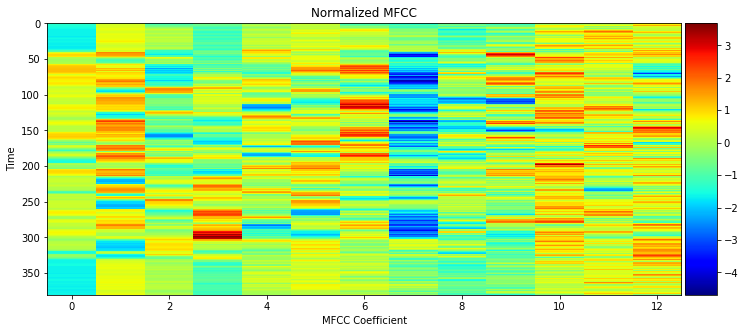

**Shape of MFCC** : (381, 13)

In [5]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [3]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam, SGD ##NP
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [6]:
model_0 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=False, sort_by_duration=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 245s 2s/step - loss: 805.4245 - val_loss: 750.9767
Epoch 2/20
101/101 [==============================] - 295s 3s/step - loss: 779.5434 - val_loss: 755.3608
Epoch 3/20
101/101 [==============================] - 274s 3s/step - loss: 779.1889 - val_loss: 756.5205
Epoch 4/20
101/101 [==============================] - 280s 3s/step - loss: 779.2735 - val_loss: 761.4924
Epoch 5/20
101/101 [==============================] - 274s 3s/step - loss: 778.8810 - val_loss: 756.4274
Epoch 6/20
101/101 [==============================] - 272s 3s/step - loss: 779.2041 - val_loss: 757.3370
Epoch 7/20
101/101 [==============================] - 274s 3s/step - loss: 778.8097 - val_loss: 752.2936
Epoch 8/20
101/101 [==============================] - 275s 3s/step - loss: 779.6691 - val_loss: 759.6326
Epoch 9/20
101/101 [==============================] - 274s 3s/step - loss: 779.7735 - val_loss: 754.0988
Epoch 10/20
101/101 [==============================] - 

### Model 0: Observations
The simple model with MFCC input feeding into RNN (GRU) layer with 29 hidden units and  softmax output doesn't train well. The loss does not diminish over the epochs indicating the architecture is too simple to train.

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [2]:
model_1 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=100,
            optimizer=Adam(lr=0.001, clipnorm=1),
            #SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=True)

Epoch 1/20
20/20 [==============================] - 156s 8s/step - loss: 639.3569 - val_loss: 474.7027
Epoch 2/20
20/20 [==============================] - 152s 8s/step - loss: 456.9522 - val_loss: 416.8975
Epoch 3/20
20/20 [==============================] - 151s 8s/step - loss: 340.2614 - val_loss: 368.1061
Epoch 4/20
20/20 [==============================] - 151s 8s/step - loss: 290.2538 - val_loss: 291.5277
Epoch 5/20
20/20 [==============================] - 151s 8s/step - loss: 272.1118 - val_loss: 280.8857
Epoch 6/20
20/20 [==============================] - 152s 8s/step - loss: 258.8125 - val_loss: 249.7322
Epoch 7/20
20/20 [==============================] - 150s 7s/step - loss: 247.7202 - val_loss: 254.6059
Epoch 8/20
20/20 [==============================] - 153s 8s/step - loss: 244.4551 - val_loss: 244.5081
Epoch 9/20
20/20 [==============================] - 153s 8s/step - loss: 321.8210 - val_loss: 412.2178
Epoch 10/20
20/20 [==============================] - 153s 8s/step - loss:

### Model 1: Observations
The model with MFCC input feeding into an RNN (GRU) layer with 200 hidden relu units and a time-distributed dense softmax output layer trains better but flattens at training loss of 232, much higher than other more complex architectures below. NaN loss was addressed by using Adam optimizer and cliping weights above 1. A larger minibatch size of 100 was used to reduce training time.

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [2]:
model_2 = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=True)

Epoch 1/20
101/101 [==============================] - 110s 1s/step - loss: 234.5677 - val_loss: 251.9610
Epoch 2/20
101/101 [==============================] - 105s 1s/step - loss: 189.4796 - val_loss: 199.0585
Epoch 3/20
101/101 [==============================] - 103s 1s/step - loss: 159.4188 - val_loss: 168.8977
Epoch 4/20
101/101 [==============================] - 104s 1s/step - loss: 146.8903 - val_loss: 149.3355
Epoch 5/20
101/101 [==============================] - 106s 1s/step - loss: 138.7740 - val_loss: 147.7041
Epoch 6/20
101/101 [==============================] - 104s 1s/step - loss: 132.7288 - val_loss: 137.8710
Epoch 7/20
101/101 [==============================] - 105s 1s/step - loss: 128.8724 - val_loss: 136.8881
Epoch 8/20
101/101 [==============================] - 106s 1s/step - loss: 124.8424 - val_loss: 135.8469
Epoch 9/20
101/101 [==============================] - 103s 1s/step - loss: 121.7911 - val_loss: 133.5765
Epoch 10/20
101/101 [==============================] - 

### Model 2: Observations
The model with MFCC input feeding into an CNN layer (200 filters, kernel size 11, and stride of 2), RNN (SimpleRNN) layer with 200 hidden relu units, and a time-distributed dense softmax output layer trains better and continues to show reduced loss through 20 epochs (with min validation loss of 128) indicating more complex architecture and/or more epochs may be used for better performance. The model overfitted the training data. Each CNN and RNN layer is followed with batch normalization layer for faster training. 

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [3]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2,
                         recur_type=GRU) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         217200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn2 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [4]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 274s 3s/step - loss: 263.5553 - val_loss: 226.8124
Epoch 2/20
101/101 [==============================] - 435s 4s/step - loss: 227.4463 - val_loss: 215.9015
Epoch 3/20
101/101 [==============================] - 437s 4s/step - loss: 208.4624 - val_loss: 210.8183
Epoch 4/20
101/101 [==============================] - 439s 4s/step - loss: 182.7990 - val_loss: 204.8395
Epoch 5/20
101/101 [==============================] - 438s 4s/step - loss: 159.6790 - val_loss: 187.8356
Epoch 6/20
101/101 [==============================] - 436s 4s/step - loss: 147.0689 - val_loss: 176.3760
Epoch 7/20
101/101 [==============================] - 433s 4s/step - loss: 139.5560 - val_loss: 165.8921
Epoch 8/20
101/101 [==============================] - 440s 4s/step - loss: 132.2771 - val_loss: 165.0298
Epoch 9/20
101/101 [==============================] - 441s 4s/step - loss: 127.4617 - val_loss: 155.7426
Epoch 10/20
101/101 [==============================] - 

### Model 3: Observations
The model with Spectrogram input feeding into two RNN (GRU) layers with 200 hidden relu units, and a time-distributed dense softmax output layer trains slower than CNN-RNN model with minimum validation loss of 144. The model continued to improve validation loss throughout indicating greater architectural complexity and/or more epochs can result in better performance. The model overfitted the training data. Each RNN layer is followed with batch normalization layer for faster training. 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [4]:
model_4 = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
bn_bidir_rnn (BatchNormaliza (None, None, 400)         1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 270,029
Trainable params: 269,229
Non-trainable params: 800
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=100,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4),
            sort_by_duration=True) # change to False if you would like to use MFCC features

Epoch 1/20
20/20 [==============================] - 167s 8s/step - loss: 471.3330 - val_loss: 641.2085
Epoch 2/20
20/20 [==============================] - 174s 9s/step - loss: 292.8575 - val_loss: 553.6673
Epoch 3/20
20/20 [==============================] - 175s 9s/step - loss: 277.3899 - val_loss: 481.1956
Epoch 4/20
20/20 [==============================] - 177s 9s/step - loss: 268.5778 - val_loss: 434.4135
Epoch 5/20
20/20 [==============================] - 177s 9s/step - loss: 263.5826 - val_loss: 396.6129
Epoch 6/20
20/20 [==============================] - 176s 9s/step - loss: 260.0331 - val_loss: 404.0238
Epoch 7/20
20/20 [==============================] - 176s 9s/step - loss: 255.4651 - val_loss: 367.5384
Epoch 8/20
20/20 [==============================] - 174s 9s/step - loss: 251.7933 - val_loss: 334.1919
Epoch 9/20
20/20 [==============================] - 176s 9s/step - loss: 247.8565 - val_loss: 322.7917
Epoch 10/20
20/20 [==============================] - 175s 9s/step - loss:

### Model 4: Observations
The model with MFCC input feeding into a bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer train ought to train similar to 2 RNN layers as in Model 3. However a larger minibatch size of 100 was used to experiement with training time; the training time was much better but at the expense of performance. A smaller batch size needs to be used to yield a better value for loss within 20 epochs.More experiments with Bidirectional layer are conducted later to gather more definitive results.

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

### Model 5: CNN + Bidirectional RNN + Time-Distributed Dense

In [2]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.
# Model 5: Convolutional + Bidirectional RNN (SimpleRNN) + Time Distributed Dense layers
model_5 = cnn_birnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        rnn_type=SimpleRNN)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         160400    
_________________________________________________________________
bn_bidir_rnn (BatchNormaliza (None, None, 400)         1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [ ]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False)

Epoch 1/20
101/101 [==============================] - 131s 1s/step - loss: 251.6353 - val_loss: 221.0808
Epoch 2/20
101/101 [==============================] - 113s 1s/step - loss: 183.0815 - val_loss: 183.6336
Epoch 3/20
101/101 [==============================] - 113s 1s/step - loss: 155.7737 - val_loss: 184.0128
Epoch 4/20
101/101 [==============================] - 113s 1s/step - loss: 141.4353 - val_loss: 176.5411
Epoch 5/20
101/101 [==============================] - 113s 1s/step - loss: 132.1154 - val_loss: 164.0104
Epoch 6/20
101/101 [==============================] - 115s 1s/step - loss: 124.7147 - val_loss: 162.8083
Epoch 7/20
101/101 [==============================] - 112s 1s/step - loss: 119.3572 - val_loss: 173.9365
Epoch 8/20
101/101 [==============================] - 110s 1s/step - loss: 114.2579 - val_loss: 162.0644
Epoch 9/20
101/101 [==============================] - 114s 1s/step - loss: 110.5269 - val_loss: 164.5173
Epoch 10/20
101/101 [==============================] - 

### Model 5: Observations
The model with MFCC input feeding into an CNN layer (200 filters, kernel size 11, and stride of 2), bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains better. It continued to improve loss indicating further improvement should be possible with greather architectural complexity and/or more epochs. A minimum validation loss of 131 was achieved. The model overfitted the training data. Using SimpleRNN instead of GRU seemed to work better in gradually reducing the loss.

### Model 6: Dilated CNN + Bidirectional RNN + Time-Distributed Dense

In [2]:
# Model 6: Dilated CNN +   Bidirectional RNN + 
#   Time Distributed Dense layers
# Note: For dilated CNN, conv_border_mode is "causal", and stride must be 
#       1 for dilation_rate other than 1. Therefore conv_border_mode and
#       conv_stride are assumed "causal" and 1 respectively.
model_6 = dilated_cnn_birnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        dilation = 2,  
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_bidir_rnn (BatchNormaliza (None, None, 400)         1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [3]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False)

Epoch 1/20
101/101 [==============================] - 417s 4s/step - loss: 280.8962 - val_loss: 249.1433
Epoch 2/20
101/101 [==============================] - 411s 4s/step - loss: 216.0234 - val_loss: 191.7879
Epoch 3/20
101/101 [==============================] - 410s 4s/step - loss: 179.8790 - val_loss: 170.5357
Epoch 4/20
101/101 [==============================] - 412s 4s/step - loss: 158.3930 - val_loss: 153.6604
Epoch 5/20
101/101 [==============================] - 410s 4s/step - loss: 145.3477 - val_loss: 150.2241
Epoch 6/20
101/101 [==============================] - 411s 4s/step - loss: 135.6290 - val_loss: 144.3130
Epoch 7/20
101/101 [==============================] - 412s 4s/step - loss: 127.6588 - val_loss: 140.4491
Epoch 8/20
101/101 [==============================] - 411s 4s/step - loss: 121.0464 - val_loss: 142.6626
Epoch 9/20
101/101 [==============================] - 412s 4s/step - loss: 115.0388 - val_loss: 138.9597
Epoch 10/20
101/101 [==============================] - 

### Model 6: Observations
The model with MFCC input feeding into a dilated CNN layer (200 filters, kernel size 11, dilation of 2, stride of 1), bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains worse than non-dilated version and showed minuimum validation loss of 136 and overfitted the training data over 20 epochs. 

### Model 7: 2 CNNs with MaxPool + Bidirectional RNN + Time-Distributed Dense

In [5]:
# Model 7: deep CNN with MaxPool +  Bidirectional RNN + 
#   Time Distributed Dense layers
model_7 = deep_cnn_birnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=100,
                        kernel_size=9, 
                        conv_stride=1,
                        conv_border_mode='same',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 100)         11800     
_________________________________________________________________
max_pool_1D_1 (MaxPooling1D) (None, None, 100)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 100)         90100     
_________________________________________________________________
max_pool_1D_2 (MaxPooling1D) (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         361200    
_________________________________________________________________
bn_bidir_rnn_1 (BatchNormali (None, None, 400)         1600      
__________

In [7]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=True)

Epoch 1/20
101/101 [==============================] - 133s 1s/step - loss: 208.0655 - val_loss: 199.0136
Epoch 2/20
101/101 [==============================] - 150s 1s/step - loss: 180.5293 - val_loss: 175.4750
Epoch 3/20
101/101 [==============================] - 149s 1s/step - loss: 168.2159 - val_loss: 167.3314
Epoch 4/20
101/101 [==============================] - 149s 1s/step - loss: 159.4308 - val_loss: 163.6615
Epoch 5/20
101/101 [==============================] - 148s 1s/step - loss: 152.3680 - val_loss: 159.0279
Epoch 6/20
101/101 [==============================] - 149s 1s/step - loss: 146.3791 - val_loss: 157.0153
Epoch 7/20
101/101 [==============================] - 148s 1s/step - loss: 141.3624 - val_loss: 152.1200
Epoch 8/20
101/101 [==============================] - 151s 1s/step - loss: 136.8158 - val_loss: 149.6230
Epoch 9/20
101/101 [==============================] - 150s 1s/step - loss: 132.4429 - val_loss: 147.8540
Epoch 10/20
101/101 [==============================] - 

### Model 7: Observations
The model with MFCC input feeding into two CNN layers (100 filters, kernel size 11, stride of 2) each followed by a Max-Pool layer (pool size of 2), a bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains worse than a single CNN layer with no MaxPool. It showed minumum training loss of 147 and overfitted the training data over 20 epochs.

### Model 8: 2 CNNs with MaxPool + 2 Bidirectional RNNs + Time-Distributed Dense

In [2]:
# Model 8: deep CNN +  deep Bidirectional RNN + 
#   Time Distributed Dense layers
model_8 = deep_cnn_deep_birnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=1,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         28800     
_________________________________________________________________
max_pool_1D_1 (MaxPooling1D) (None, None, 200)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 200)         440200    
_________________________________________________________________
max_pool_1D_2 (MaxPooling1D) (None, None, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_bidir_rnn_1 (BatchNormali (None, None, 400)         1600      
__________

In [3]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_8.pickle', 
            save_model_path='model_8.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=True)

Epoch 1/20
101/101 [==============================] - 152s 2s/step - loss: 213.6526 - val_loss: 207.1825
Epoch 2/20
101/101 [==============================] - 217s 2s/step - loss: 179.5879 - val_loss: 176.6854
Epoch 3/20
101/101 [==============================] - 217s 2s/step - loss: 162.3654 - val_loss: 160.6933
Epoch 4/20
101/101 [==============================] - 216s 2s/step - loss: 150.1586 - val_loss: 154.4602
Epoch 5/20
101/101 [==============================] - 216s 2s/step - loss: 140.7869 - val_loss: 154.4712
Epoch 6/20
101/101 [==============================] - 216s 2s/step - loss: 131.5787 - val_loss: 147.4490
Epoch 7/20
101/101 [==============================] - 219s 2s/step - loss: 123.7816 - val_loss: 150.0245
Epoch 8/20
101/101 [==============================] - 217s 2s/step - loss: 116.3373 - val_loss: 154.9933
Epoch 9/20
101/101 [==============================] - 219s 2s/step - loss: 108.6518 - val_loss: 147.8838
Epoch 10/20
101/101 [==============================] - 

### Model 8: Observations
The model with MFCC input feeding into two CNN layers (200 filters, kernel size 11, stride of 2) each followed by a Max-Pool layer (pool size of 2), two bidirectional RNN (GRU) layers with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer has similar validation loss (147) as with one Bidirectional RNN layer in Model 7, but shows greater overfitting on training data.

### Model 9: CNN + Bidirectional RNN + Time-Distributed Dense (with Spectrogram)

In [2]:
# Try with Spectrogram to see if validation loss improves with same parameters
model_9 = cnn_birnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200,
                        rnn_type=GRU)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_bidir_rnn (BatchNormaliza (None, None, 400)         1600      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [6]:
train_model(input_to_softmax=model_9, 
            pickle_path='model_9.pickle', 
            save_model_path='model_9.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False)

Epoch 1/20
101/101 [==============================] - 186s 2s/step - loss: 253.8482 - val_loss: 258.2696
Epoch 2/20
101/101 [==============================] - 188s 2s/step - loss: 188.4461 - val_loss: 176.2341
Epoch 3/20
101/101 [==============================] - 187s 2s/step - loss: 157.6192 - val_loss: 158.2084
Epoch 4/20
101/101 [==============================] - 187s 2s/step - loss: 141.4580 - val_loss: 144.4932
Epoch 5/20
101/101 [==============================] - 188s 2s/step - loss: 130.0811 - val_loss: 138.0650
Epoch 6/20
101/101 [==============================] - 187s 2s/step - loss: 121.2936 - val_loss: 137.2824
Epoch 7/20
101/101 [==============================] - 186s 2s/step - loss: 113.9498 - val_loss: 134.3511
Epoch 8/20
101/101 [==============================] - 187s 2s/step - loss: 106.9801 - val_loss: 133.4086
Epoch 9/20
101/101 [==============================] - 188s 2s/step - loss: 100.9813 - val_loss: 131.6989
Epoch 10/20
101/101 [==============================] - 

### Model 9: Observations
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), a bidirectional RNN (GRU) layers with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains better with training loss continuing to drop to 46 at Epoch 20 and minimum validation loss of 131 at Epoch 10. The model overfitted the training data.

### Model 10: CNN + 2 RNNs + Time-Distributed Dense (with Spectrogram)

In [2]:
model_10 = cnn_deep_rnn_model(input_dim=161, 
                            filters=200, 
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid', 
                            rnn_type=GRU,
                            units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn2 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn2 (BatchNormalization) (None, None, 200)         800       
__________

In [3]:
# Train with smaller batch size
train_model(input_to_softmax=model_10, 
            pickle_path='model_10.pickle', 
            save_model_path='model_10.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False) 

Epoch 1/20
101/101 [==============================] - 218s 2s/step - loss: 238.8390 - val_loss: 219.3236
Epoch 2/20
101/101 [==============================] - 215s 2s/step - loss: 175.5795 - val_loss: 168.7546
Epoch 3/20
101/101 [==============================] - 216s 2s/step - loss: 146.4972 - val_loss: 146.8657
Epoch 4/20
101/101 [==============================] - 215s 2s/step - loss: 131.3827 - val_loss: 138.9854
Epoch 5/20
101/101 [==============================] - 215s 2s/step - loss: 121.0086 - val_loss: 135.8133
Epoch 6/20
101/101 [==============================] - 214s 2s/step - loss: 112.2463 - val_loss: 135.6373
Epoch 7/20
101/101 [==============================] - 215s 2s/step - loss: 104.9601 - val_loss: 130.2342
Epoch 8/20
101/101 [==============================] - 215s 2s/step - loss: 98.5069 - val_loss: 129.0089
Epoch 9/20
101/101 [==============================] - 214s 2s/step - loss: 92.4587 - val_loss: 126.7460
Epoch 10/20
101/101 [==============================] - 21

### Model 10: Observations
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), two RNN (GRU) layers with 200 hidden relu units, and a time-distributed dense softmax output layer trains slightly better than CNN-Bidirectional RNN model with training loss continuing to drop to 44 at Epoch 20 and minimum validation loss of 126 at Epoch 9. The model overfitted the training data.

### Model 11: CNN + 4 Bidirectional RNNs + Time-Distributed Dense (with Spectrogram)

In [10]:
model_11 = cnn_deep_birnn_model(input_dim=161, 
                            filters=200, 
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid',
                            recur_layers=4,
                            rnn_type=SimpleRNN,
                            rnn_dropout=0,
                            units=200)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 400)         160400    
_________________________________________________________________
bn_birnn1 (BatchNormalizatio (None, None, 400)         1600      
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 400)         240400    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

In [11]:
# Train with smaller batch size
train_model(input_to_softmax=model_11, 
            pickle_path='model_11.pickle', 
            save_model_path='model_11.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False) 

Epoch 1/20
101/101 [==============================] - 198s 2s/step - loss: 247.2978 - val_loss: 228.2169
Epoch 2/20
101/101 [==============================] - 199s 2s/step - loss: 169.9166 - val_loss: 157.8182
Epoch 3/20
101/101 [==============================] - 196s 2s/step - loss: 139.9997 - val_loss: 143.4736
Epoch 4/20
101/101 [==============================] - 199s 2s/step - loss: 123.6299 - val_loss: 134.3921
Epoch 5/20
101/101 [==============================] - 197s 2s/step - loss: 111.7535 - val_loss: 126.6331
Epoch 6/20
101/101 [==============================] - 198s 2s/step - loss: 102.6043 - val_loss: 124.7157
Epoch 7/20
101/101 [==============================] - 200s 2s/step - loss: 94.4991 - val_loss: 123.1418
Epoch 8/20
101/101 [==============================] - 196s 2s/step - loss: 87.6188 - val_loss: 122.0977
Epoch 9/20
101/101 [==============================] - 198s 2s/step - loss: 81.0043 - val_loss: 121.1846
Epoch 10/20
101/101 [==============================] - 199

### Model 11: Observations
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), 4 bidirectional RNN (SimpleRNN) layers with 200 hidden relu units, and a time-distributed dense softmax output layer has the best performance in terms of lowest validation loss (121). The model also overfitted the training data.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

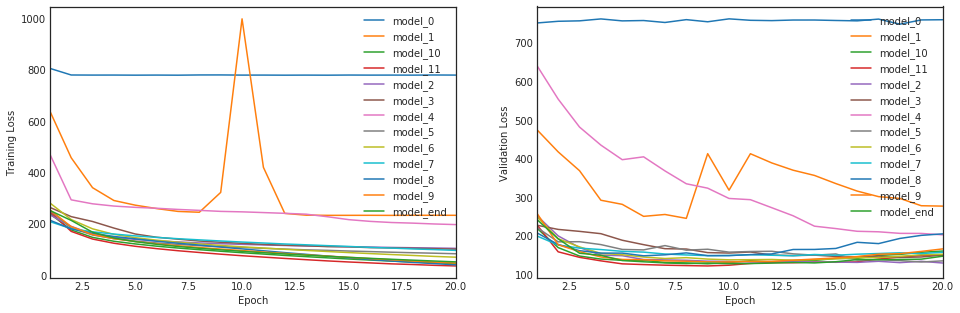

In [2]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ 

__Model 0: MFCC input + RNN (GRU). 
Min val loss: 747  epoch 18, Train loss at epoch 20: 779, Training time per epoch: 280s__ 
The simple model with MFCC input feeding into RNN (GRU) layer with 29 hidden units and  softmax output doesn't train well. The loss does not diminish over the epochs indicating the architecture is too simple to train. 

__Model 1: MFCC input + RNN (GRU) + Time-Distributed Dense. 
Min val loss: 244 at epoch 8, Train loss at epoch 20: 233, Training time per epoch: 155s__
The model with MFCC input feeding into an RNN (GRU) layer with 200 hidden relu units and a time-distributed dense softmax output layer trains better but flattens at training loss of 232, much higher than other more complex architectures below. NaN loss was addressed by using Adam optimizer and cliping weights above 1. A larger minibatch size of 100 was used to reduce training time.

__Model 2: Spectrogram input + CNN + RNN (SimpleRNN) + Time-Distributed Dense.
Min val loss: 128 at epoch 20, Train loss at epoch 20: 104, Training time per epoch: 105s__
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, and stride of 2), RNN (SimpleRNN) layer with 200 hidden relu units, and a time-distributed dense softmax output layer trains better and continues to show reduced loss through 20 epochs (with min validation loss of 128) indicating more complex architecture and/or more epochs should be used for better performance. Each CNN and RNN layer is followed with batch normalization layer for faster training. 

__Model 3: Spectrogram input + 2 RNNs (GRU) + Time-Distributed Dense.
Min val loss: 143 at epoch 18, Train loss at epoch 20: 101, Training time per epoch: 440s__
The model with Spectrogram input feeding into two RNN (GRU) layers with 200 hidden relu units, and a time-distributed dense softmax output layer trains slower than CNN-RNN model with minimum validation loss of 144. The model continued to improve validation loss throughout indicating that a greater architectural complexity and/or more epochs can result in better performance. Each RNN layer is followed with batch normalization layer for faster training. 

__Model 4: MFCC input + Bidirectional RNN (GRU) + Time-Distributed Dense.
Min val loss: 201 at epoch 20, Train loss at epoch 20: 196, Training time per epoch: 178s__
The model with MFCC input feeding into a bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer train ought to train similar to 2 RNN layers as in Model 3. However a larger minibatch size of 100 was used to experiement with training time; the training time was much better but at the expense of performance. A smaller batch size needs to be used to yield a better value for loss within 20 epochs.More experiments with Bidirectional layer are conducted later to gather more definitive results.

__Model 5: MFCC input + CNN + Bidirectional RNN (SimpleRNN) + Time-Distributed Dense.
Min val loss: 131 at epoch 20, Train loss at epoch 20: 83, Training time per epoch: 114s__
The model with MFCC input feeding into an CNN layer (200 filters, kernel size 11, and stride of 2), bidirectional RNN (SimpleRNN) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains better. It continued to improve loss indicating further improvement should be possible with greather architectural complexity and/or more epochs. A minimum validation loss of 131 was achieved. The model overfitted the training data. Using SimpleRNN instead of GRU seemed to work better in gradually reducing the loss.

__Model 6: MFCC input + Dilated CNN + Bidirectional RNN (GRU) + Time-Distributed Dense.
Min val loss: 136 at epoch 13, Train loss at epoch 20: 69, Training time per epoch: 412s__
The model with MFCC input feeding into a dilated CNN layer (200 filters, kernel size 11, dilation of 2, stride of 1), bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains slightly worse than non-dilated version and showed minuimum validation loss of 136 and overfitted the training data over 20 epochs. 

__Model 7: MFCC input + 2 CNNs with MaxPooling + Bidirectional RNN (GRU) + Time-Distributed Dense.
Min val loss: 147 at epoch 13, Train loss at epoch 20: 96, Training time per epoch: 150s__
The model with MFCC input feeding into two CNN layers (100 filters, kernel size 11, stride of 2) each followed by a Max-Pool layer (pool size of 2), a bidirectional RNN (GRU) layer with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains worse than a single CNN layer with no MaxPool. It showed minumum training loss of 147 and overfitted the training data over 20 epochs.

__Model 8: MFCC input + 2 CNNs with MaxPooling + 2 Bidirectional RNNs (GRU) + Time-Distribted Dense.
Min val loss: 147 at epoch 9, Train loss at epoch 20: 39, Training time per epoch: 218s__
The model with MFCC input feeding into two CNN layers (200 filters, kernel size 11, stride of 2) each followed by a Max-Pool layer (pool size of 2), two bidirectional RNN (GRU) layers with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer has similar validation loss (147) as with one Bidirectional RNN layer in Model 7, but shows even greater overfitting on training data.

__Model 9: Spectrogram input + CNN + Bidirectional RNN (GRU) + Time-Distributed Dense.
Min val loss: 131 at epoch 10, Train loss at epoch 20: 46, Training time per epoch: 188s__
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), a bidirectional RNN (GRU) layers with 200 hidden relu units in each direction, and a time-distributed dense softmax output layer trains better with training loss continuing to drop to 46 at Epoch 20 and minimum validation loss of 131 at Epoch 10. The model overfitted the training data.

__Model 10: Spectrogram input + CNN + 2 RNNs (GRU) + Time-Distributed Dense.
Min val loss: 126 at epoch 9, Train loss at epoch 20: 44, Training time per epoch: 215s__
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), 2 RNN (GRU) layers with 200 hidden relu units, and a time-distributed dense softmax output layer trains better than CNN-Bidirectional RNN model with training loss continuing to drop to 44 at Epoch 20 and minimum validation loss of 126 at Epoch 9. The model overfitted the training data like most other models.

__Model 11: Spectrogram input + CNN + 4 Bidirectional RNNs (SimpleRNN) + Time-Distributed Dense.
Min val loss: 121 at epoch 9, Train loss at epoch 20: 35, Training time per epoch: 196s__
The model with Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), 4 bidirectional RNN (SimpleRNN) layers with 200 hidden relu units, and a time-distributed dense softmax output layer has the best performance in terms of lowest validation loss (121). The model also overfitted the training data.


__GENERAL OBSERVATIONS:__

__Use of CNN:__ A convolution layer at the beginning improved performance as well as training time in general.

__Overfitting:__ Most models overfitted the training data. While they continued to improve training loss, the validation loss flattened and bounced back, and divergence increased between training and validation losses. 

__Regualization:__ Regulation was insuccessfully attempted by using dropout and recurrent_dropout parameters to Keras's recurrent layers. It resulted in a NaN loss, or untrainable model where the loss will not diminish over epochs. Also a dropout layer after CNN impacted the performance of the model. More investigation is needed here, but was limited by the GPU time.

__Training Data:__ For lack of better regularization which can help with overfitting, more training data could have helped train the models better and resulted in lower validation loss. However for lack of (GPU) time, this is a note for future improvements.

__Dilation:__ Experimented with dialtion (with dilation factor of 2). Keras restricts the stride to 1. However, based on the experiments, regular (non-dilated) CNN produced better validation loss. Output length formula was adjusted for "causal" mode.

__Deep CNNs with MaxPooling:__ Experimented with multiple CNN layers and MaxPooling. Keras restricts the stride to 1. However, based on the experiments, a single regular CNN layer without max-pooling proruced better validation loss. Output length formula had to be nested for multiple CNNs.

__MFCC vs Spectrogram:__ The models seemed to train better on Spectrogram data as they produced lower validation loss. However there seemed to be a greater divergence between training and validation losses with Spectrogram.

__CNN hyperparameters:__ After varying the filters, kernel size, and stride parameters, the conclusion was the provided values (200 filters, 11 kernel size, and 2 stride size) work best.


__EXPLANATION FOR BETTER PERFORMANCE OF SOME MODELS OVER OTHERS:__

In general the models that used Spectrogram input, a CNN, one or more SimpleRNN worked best for both validation loss and training time.

__Too simple and untrainable:__ Models 0 and 1 were too simple to train effectively. Key elements that needed to be present in each model for reasonable trainability and performance are a) one or more RNN layer connected to b) a Time-Distributed Dense output layer.

__Mini-batch size:__ An attempt to use a much larger mini-batch size of 100 in order to reduce the training time in Model 4 did not work in spite of the use of CNN and Bidirectional RNN. Models trained better with small batch size (of 20) although it took much longer to train the models. With only 20 epochs, smaller mini-batches allowed more and finer iterations for adjusting weights in the training process which worked better.

__Use of CNN helps performance and training time:__ Use of a CNN as the first layer helped both in performance and reducing the training time. Compare Models 1, 3 and 4 (RNN, deep RNN, and bidirectional RNN with no CNN) with Models 3, 5-11 (all with a CNN) clearly illustrates this. Use of dilation (Model 6) or multiple CNNs (Models 7 and 8) didn't seem to improve the performance over a single CNN (Models 2, 5, 9-11), but didn't harm it badly either. Convolution filters effectively represent the features in the time proximity of audio, and therefore improve time and loss characteristics of the model.

__Better training with Spectrogram vs MFCC:__ All models with lowest validation losses (in 120's) used Spectrogram, whereas the lowest validation loss with MFCC was 128 (Model 5, CNN + Bidirectional SimpleRNN).This perhaps has to do with the greater details available in Spectrogram features.

__Better training with SimpleNN vs GRU:__ All models with lowest validation losses (in 120's) used SimpleRNN (Models 2 and 11) whereas the lowest validation loss with GRU was 131 (Model 9, CNN + Bidirectional GRU). GRU also took longer to train. This perhaps has to do with more complexity of GRU over SimpleRNN that overfitted to training data faster causing validation loss to not continue to go down.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [4]:
# specify the model
# Spectrogram input + CNN + 3 Bidirectional RNNs (SimpleRNN) + Time-Distributed Dense

model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers=3, 
                        rnn_type=SimpleRNN, 
                        units=200)

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         160400    
_________________________________________________________________
bn_birnn1 (BatchNormalizatio (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         240400    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            minibatch_size=20,
            #optimizer=Adam(lr=0.001, clipnorm=1),
            optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
            sort_by_duration=False)

Epoch 1/20
101/101 [==============================] - 172s 2s/step - loss: 236.5591 - val_loss: 208.6514
Epoch 2/20
101/101 [==============================] - 170s 2s/step - loss: 166.3904 - val_loss: 156.1326
Epoch 3/20
101/101 [==============================] - 172s 2s/step - loss: 140.8542 - val_loss: 143.7944
Epoch 4/20
101/101 [==============================] - 168s 2s/step - loss: 125.4152 - val_loss: 135.6079
Epoch 5/20
101/101 [==============================] - 169s 2s/step - loss: 114.6666 - val_loss: 132.8304
Epoch 6/20
101/101 [==============================] - 169s 2s/step - loss: 105.3304 - val_loss: 129.3574
Epoch 7/20
101/101 [==============================] - 167s 2s/step - loss: 97.7274 - val_loss: 131.3391
Epoch 8/20
101/101 [==============================] - 167s 2s/step - loss: 91.0952 - val_loss: 124.4767
Epoch 9/20
101/101 [==============================] - 166s 2s/step - loss: 85.1613 - val_loss: 123.7782
Epoch 10/20
101/101 [==============================] - 165

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

__Final model: Spectrogram input + CNN + 3 Bidirectional RNNs (SimpleRNN) + Time-Distributed Dense.
Min val loss: 122 at epoch 10, Train loss at epoch 20: 38, Training time per epoch: 163s__
The model has Spectrogram input feeding into a CNN layer (200 filters, kernel size 11, stride of 2), 3 bidirectional RNN (SimpleRNN) layers with 200 hidden relu units, and a time-distributed dense softmax output layer.

It resembles Model 11 that produced the best performance in terms of validation loss within reasonable training time. 

As explained in the observations from Answer 1 above, the key reasons for this choice are:
- __Spectrogram input:__ Seems to produce lower validation loss than MFCC.
- __1 CNN layer:__ Results in better training performance and time
- __Multiple Bidirectional SimpleRNN layers:__ Multiple bidirectional layers provide better performance. SimpleRNN has better performance than GRU with lower training time.
- __Batch normalization after each CNN and RNN layer:__ To speed up training.
- __Time-Distributed Dense (softmax):__ As output layer
- __Hyperparameters that worked__ (200 filters/11 kernel size/2 stride, mini-batch size of 20, SGD optimizer with default parameters, 200 units in each RNN layer)

Note the training could be stopped early after the 10th epoch where the minimum validation loss is attained. 

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [6]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=True)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [9]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers=3, 
                        rnn_type=SimpleRNN, 
                        units=200), 
                model_path='results/model_end.h5')

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         160400    
_________________________________________________________________
bn_birnn1 (BatchNormalizatio (None, None, 400)         1600      
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         240400    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [11]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        recur_layers=3, 
                        rnn_type=SimpleRNN, 
                        units=200), 
                model_path='results/model_end.h5')

/opt/conda/lib/python3.6/site-packages/keras/layers/recurrent.py:1004: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 400)         160400    
_________________________________________________________________
bn_birnn1 (BatchNormalizatio (None, None, 400)         1600      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 400)         240400    
_________________________________________________________________
bn_birnn2 (BatchNormalizatio (None, None, 400)         1600      
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!